In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# check if using cuda
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device: {device}')

device: cuda


# Load data and split

In [4]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])

In [5]:
# train = pd.read_csv(out, header=None, names=feature_columns)
train = pd.read_csv('data/forest-cover-type.csv', header=None, names=feature_columns)
# train = pd.read_csv('data/synthetic_easy.csv', header=None)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [6]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [7]:
# This is a generic pipeline but actually no categorical features are available for this dataset

unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [8]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [9]:
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_valid.shape: {X_valid.shape}, y_valid.shape: {y_valid.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (309872, 54), y_train.shape: (309872,)
X_valid.shape: (154937, 54), y_valid.shape: (154937,)
X_test.shape: (116203, 54), y_test.shape: (116203,)


# Network parameters

In [10]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [11]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/home/paritosh/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Self Supervised Training

In [12]:
max_epochs = 1000 if not os.getenv("CI", False) else 2 # 1000
# max_epochs = 10 if not os.getenv("CI", False) else 2

In [13]:
# unsupervised_model.fit(
#     X_train=X_train,
#     eval_set=[X_valid],
#     max_epochs=max_epochs , patience=5,
#     batch_size=2048, virtual_batch_size=128,
#     num_workers=0,
#     drop_last=False,
#     pretraining_ratio=0.5,
# ) 

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=0,
    batch_size=4096, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

/home/paritosh/workspace/tabnet/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 73.43886| val_0_unsup_loss_numpy: 9.36476993560791|  0:00:05s
epoch 5  | loss: 9.04751 | val_0_unsup_loss_numpy: 257.0727844238281|  0:00:29s
epoch 10 | loss: 5.34902 | val_0_unsup_loss_numpy: 3891.45751953125|  0:00:52s
epoch 15 | loss: 5.14967 | val_0_unsup_loss_numpy: 1196.85107421875|  0:01:14s
epoch 20 | loss: 3.9702  | val_0_unsup_loss_numpy: 104.57433319091797|  0:01:37s
epoch 25 | loss: 3.82389 | val_0_unsup_loss_numpy: 1984.650390625|  0:02:00s
epoch 30 | loss: 4.83238 | val_0_unsup_loss_numpy: 462.0274658203125|  0:02:23s
epoch 35 | loss: 4.59304 | val_0_unsup_loss_numpy: 632.0960083007812|  0:02:46s
epoch 40 | loss: 3.3085  | val_0_unsup_loss_numpy: 449.5375061035156|  0:03:09s
epoch 45 | loss: 3.41806 | val_0_unsup_loss_numpy: 280.5318298339844|  0:03:32s
epoch 50 | loss: 3.23621 | val_0_unsup_loss_numpy: 186.3553924560547|  0:03:54s
epoch 55 | loss: 3.50086 | val_0_unsup_loss_numpy: 132.52859497070312|  0:04:16s
epoch 60 | loss: 3.03828 | val_0_unsup_loss_

In [14]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [15]:
# Obtain class-balanced samples from the training data
train_balanced = train.groupby(target, group_keys=False).apply(lambda x: x.sample(n=1000, random_state=42))

X_train_balanced = train_balanced[features].values
y_train_balanced = train_balanced[target].values

# Extract embeddings using the pretrained model
_, embedded_X_train_balanced = unsupervised_model.predict(X_train_balanced)

# Verify the shape of the extracted embeddings
print("Embeddings shape:", embedded_X_train_balanced.shape)
print("Number of samples:", len(y_train_balanced))

Embeddings shape: (7000, 54)
Number of samples: 7000


In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
tsne_embeddings = tsne.fit_transform(embedded_X_train_balanced)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.000s...
[t-SNE] Computed neighbors for 7000 samples in 0.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 156.271093
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.165871
[t-SNE] KL divergence after 1000 iterations: 1.011721


iVAT Processing: 100%|██████████| 6999/6999 [00:00<00:00, 15269.98it/s]


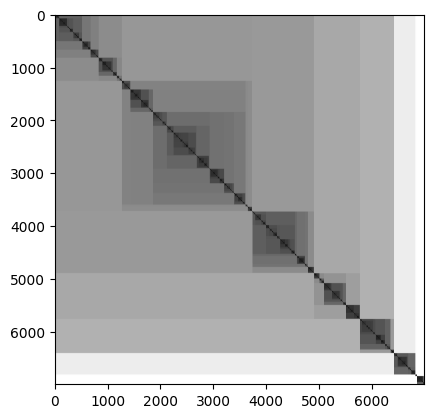

In [17]:
from VAT_library.iVAT import iVAT
from scipy.spatial.distance import cdist

pairwise_dist = cdist(tsne_embeddings, tsne_embeddings)

RiV, RV, reordering_mat = iVAT(pairwise_dist)

plt.imshow(RiV, cmap='gray')
plt.savefig('saved_models/forest_cov_type/embed_2D.png')

iVAT Processing: 100%|██████████| 6999/6999 [00:00<00:00, 17210.69it/s]


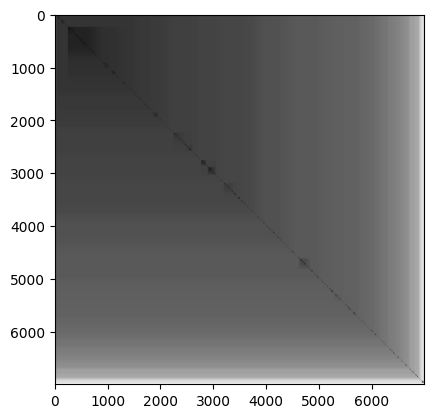

In [18]:
pairwise_dist = cdist(embedded_X_train_balanced, embedded_X_train_balanced)

RiV, RV, reordering_mat = iVAT(pairwise_dist)

plt.imshow(RiV, cmap='gray')
plt.savefig('saved_models/forest_cov_type/raw_embed_2D.png')

In [19]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

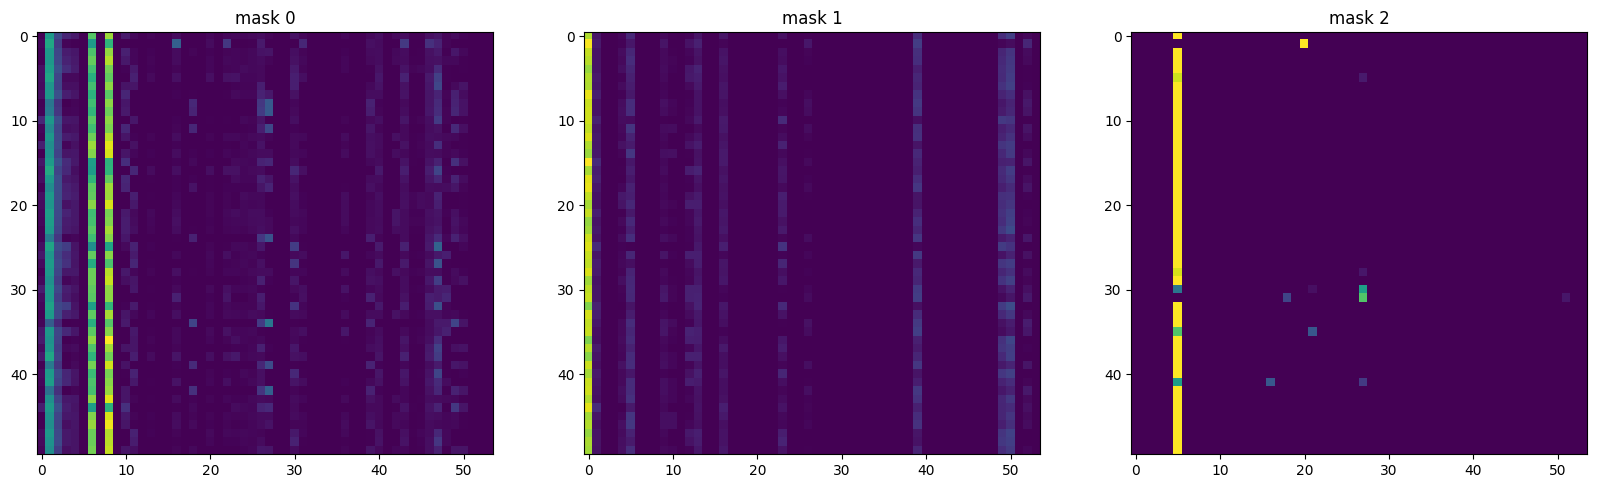

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


In [21]:
unsupervised_model.save_model('saved_models/forest_cov_type/forest_cov_type_1000_epochs')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('saved_models/forest_cov_type/forest_cov_type_1000_epochs.zip')

Successfully saved model at saved_models/forest_cov_type/forest_cov_type_1000_epochs.zip


/home/paritosh/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
